In [ ]:
!nvidia-smi


Sun Nov 30 09:38:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!nvidia-smi

Sun Nov 30 09:38:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install -q transformers datasets evaluate accelerate -U


In [ ]:
!pip install --upgrade transformers

In [ ]:
import torch
import random
import numpy as np
from datasets import load_dataset

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [ ]:
amazon = load_dataset("amazon_polarity")

# 1. Show dataset structure
print(amazon)

# 2. Show column names
print("Columns:", amazon['train'].column_names)

# 3. Size of splits
print("Train size =", len(amazon['train']))
print("Test size =", len(amazon['test']))

# 4. Show a few samples
for i in range(3):
    print(f"\nSample {i}:")
    print("  Title:", amazon['train'][i]['title'])
    print("  Content:", amazon['train'][i]['content'])
    print("  Label:", amazon['train'][i]['label'])

# 5. Check label distribution on a chunk
from collections import Counter
sample_labels = Counter(amazon['train']['label'])
print("\nLabel distribution in Amazon Train:", sample_labels)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 3600000
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 400000
    })
})
Columns: ['label', 'title', 'content']
Train size = 3600000
Test size = 400000

Sample 0:
  Title: Stuning even for the non-gamer
  Content: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
  Label: 1

Sample 1:
  Title: The best soundtrack ever to anything.
  Content: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori

In [ ]:
TRAIN_SIZE = 4000
TEST_SIZE = 1000

amazon_train = amazon['train'].shuffle(seed=SEED).select(range(TRAIN_SIZE))
amazon_test  = amazon['test'].shuffle(seed=SEED).select(range(TEST_SIZE))

len(amazon_train), len(amazon_test)


(4000, 1000)

In [ ]:
from transformers import AutoTokenizer

MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LEN = 128

# Combine title + content
def preprocess(batch):
    texts = []
    for t, c in zip(batch['title'], batch['content']):
        text = (t or "") + " " + (c or "")
        texts.append(text)
    return tokenizer(texts, truncation=True, max_length=MAX_LEN)

amazon_train = amazon_train.map(preprocess, batched=True, remove_columns=["title", "content"])
amazon_test  = amazon_test.map(preprocess, batched=True, remove_columns=["title", "content"])

amazon_train = amazon_train.rename_column("label", "labels")
amazon_test  = amazon_test.rename_column("label", "labels")

amazon_train.set_format("torch")
amazon_test.set_format("torch")


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
from transformers import (
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
import evaluate
import numpy as np

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)['accuracy'],
        "f1": f1.compute(predictions=preds, references=labels, average="weighted")['f1']
    }

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import (TrainingArguments, Trainer, IntervalStrategy)

training_args = TrainingArguments(
    output_dir="amazon_model",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    eval_strategy=IntervalStrategy.EPOCH,
    save_strategy=IntervalStrategy.EPOCH,
    logging_strategy="steps",
    logging_steps=50,
    load_best_model_at_end=True,
    fp16=True,     # faster on GPU
    report_to="none"  # cleaner output
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=amazon_train,
    eval_dataset=amazon_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-2700387330.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
train_output = trainer.train()
train_output


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.231100,0.210051,0.923000,0.922998
2,0.111500,0.262364,0.930000,0.930003


TrainOutput(global_step=500, training_loss=0.22337056827545165, metrics={'train_runtime': 63.7157, 'train_samples_per_second': 125.558, 'train_steps_per_second': 7.847, 'total_flos': 264852005187840.0, 'train_loss': 0.22337056827545165, 'epoch': 2.0})

In [ ]:
amazon_results = trainer.evaluate(amazon_test)
amazon_results


{'eval_loss': 0.21005138754844666,
 'eval_accuracy': 0.923,
 'eval_f1': 0.9229979194833033,
 'eval_runtime': 1.2918,
 'eval_samples_per_second': 774.108,
 'eval_steps_per_second': 12.386,
 'epoch': 2.0}

In [ ]:
imdb = load_dataset("imdb")

# Structure
print(imdb)

# Columns
print("Columns:", imdb['train'].column_names)

# Sizes
print("Train size =", len(imdb['train']))
print("Test size =", len(imdb['test']))

# Sample reviews
for i in range(3):
    print(f"\nIMDB Sample {i}:")
    print("  Text:", imdb['train'][i]['text'][:300], "...")
    print("  Label:", imdb['train'][i]['label'])

# Label distribution (IMDB)
from collections import Counter
print("\nLabel distribution:", Counter(imdb['train']['label']))


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})
Columns: ['text', 'label']
Train size = 25000
Test size = 25000

IMDB Sample 0:
  Text: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really h ...
  Label: 0

IMDB Sample 1:
  Text: "I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As for the claim that frontal male nudity is an automatic NC-17, that isn't true. I've seen R-rated film

In [ ]:
IMDB_TEST = 2000
imdb_test = imdb['test'].shuffle(seed=SEED).select(range(IMDB_TEST))

def preprocess_imdb(batch):
    return tokenizer(batch['text'], truncation=True, max_length=MAX_LEN)

imdb_test = imdb_test.map(preprocess_imdb, batched=True, remove_columns=["text"])
imdb_test = imdb_test.rename_column("label", "labels")
imdb_test.set_format("torch")


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
imdb_results_before = trainer.evaluate(imdb_test)
imdb_results_before


{'eval_loss': 0.40943023562431335,
 'eval_accuracy': 0.8285,
 'eval_f1': 0.8284639345422374,
 'eval_runtime': 2.2614,
 'eval_samples_per_second': 884.419,
 'eval_steps_per_second': 14.151,
 'epoch': 2.0}

In [ ]:
IMDB_TRAIN = 4000
imdb_train = imdb['train'].shuffle(seed=SEED).select(range(IMDB_TRAIN))

imdb_train = imdb_train.map(preprocess_imdb, batched=True, remove_columns=["text"])
imdb_train = imdb_train.rename_column("label", "labels")
imdb_train.set_format("torch")

ft_args = TrainingArguments(
    output_dir="imdb_finetuned",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    fp16=True,
    load_best_model_at_end=True,
    report_to="none"
)

ft_trainer = Trainer(
    model=model,   # continue training same model
    args=ft_args,
    train_dataset=imdb_train,
    eval_dataset=imdb_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

ft_trainer.train()


/tmp/ipython-input-3838338874.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  ft_trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.401500,0.360375,0.833500,0.832032
2,0.127800,0.492783,0.852500,0.852460


TrainOutput(global_step=500, training_loss=0.27786669921875, metrics={'train_runtime': 86.5953, 'train_samples_per_second': 92.384, 'train_steps_per_second': 5.774, 'total_flos': 264934797312000.0, 'train_loss': 0.27786669921875, 'epoch': 2.0})

In [ ]:
imdb_results_after = ft_trainer.evaluate(imdb_test)
imdb_results_after


{'eval_loss': 0.3603750467300415,
 'eval_accuracy': 0.8335,
 'eval_f1': 0.8320315780633241,
 'eval_runtime': 2.7467,
 'eval_samples_per_second': 728.142,
 'eval_steps_per_second': 11.65,
 'epoch': 2.0}

In [ ]:
#epochs increased to 15 in amazon model
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="amazon_model",
    num_train_epochs=15,                # ⬅️ Increased from 2 → 15
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    load_best_model_at_end=True,
    fp16=True,                          # Faster on GPU
    report_to="none"                    # Clean output
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=amazon_train,
    eval_dataset=amazon_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


/tmp/ipython-input-3100112991.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
train_output = trainer.train()
train_output

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.023700,0.511706,0.914000,0.914014
2,0.054700,0.481945,0.917000,0.917002
3,0.043300,0.544179,0.908000,0.907845
4,0.008100,0.549422,0.926000,0.926000
5,0.007800,0.749334,0.910000,0.909983
6,0.004100,0.728738,0.920000,0.919971
7,0.010800,0.679384,0.923000,0.922944
8,0.000000,0.711472,0.918000,0.917945
9,0.000000,0.753463,0.918000,0.917889
10,0.000000,0.761271,0.916000,0.915995


TrainOutput(global_step=3750, training_loss=0.012567492433389027, metrics={'train_runtime': 471.0642, 'train_samples_per_second': 127.371, 'train_steps_per_second': 7.961, 'total_flos': 1986766743073728.0, 'train_loss': 0.012567492433389027, 'epoch': 15.0})

In [ ]:
#epochs increased to 50 in amazon model
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="amazon_model",
    num_train_epochs=50,                # ⬅️ Increased from 2 → 15
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    load_best_model_at_end=True,
    fp16=True,                          # Faster on GPU
    report_to="none"                    # Clean output
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=amazon_train,
    eval_dataset=amazon_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-3159855889.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
train_output = trainer.train()
train_output

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.096000,0.421867,0.917000,0.917014
2,0.116300,0.305449,0.911000,0.911009
3,0.029000,0.533396,0.912000,0.912011
4,0.018600,0.718332,0.902000,0.901945
5,0.029000,0.684758,0.899000,0.898601
6,0.014400,0.651231,0.914000,0.914008
7,0.017200,0.580427,0.918000,0.918012
8,0.017200,0.666215,0.914000,0.913969
9,0.000100,0.670086,0.916000,0.915943
10,0.012700,0.797143,0.903000,0.902940


TrainOutput(global_step=12500, training_loss=0.008771351824402808, metrics={'train_runtime': 1612.133, 'train_samples_per_second': 124.059, 'train_steps_per_second': 7.754, 'total_flos': 6622388846128704.0, 'train_loss': 0.008771351824402808, 'epoch': 50.0})

In [ ]:
# Select a bigger dataset sample for high accuracy
TRAIN_SIZE = 80000
TEST_SIZE  = 8000

amazon_train = amazon['train'].shuffle(seed=SEED).select(range(TRAIN_SIZE))
amazon_test  = amazon['test'].shuffle(seed=SEED).select(range(TEST_SIZE))


In [ ]:
MODEL_NAME = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="amazon_roberta_model",
    num_train_epochs=4,                # 3–4 epochs gives best results
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,
    warmup_steps=1000,
    weight_decay=0.1,                  # Strong regularization improves accuracy
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    load_best_model_at_end=True,
    fp16=True,                         # Mandatory for speed
    gradient_accumulation_steps=2,      # Effective batch size = 32
    report_to="none"
)


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=amazon_train,
    eval_dataset=amazon_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()


/tmp/ipython-input-196785649.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.086700,0.182965,0.955125,0.955113
2,0.089800,0.160381,0.960000,0.960001
3,0.059100,0.185182,0.959250,0.959247
4,0.023800,0.208586,0.960500,0.960500


TrainOutput(global_step=10000, training_loss=0.06895815336704254, metrics={'train_runtime': 2327.0289, 'train_samples_per_second': 137.514, 'train_steps_per_second': 4.297, 'total_flos': 2.104073620830432e+16, 'train_loss': 0.06895815336704254, 'epoch': 4.0})

In [ ]:
#above cell with 80,000 samples + ROBERTa model - accuracy - 96.05%, epochs - 4
#model ready for imdb dataset

In [ ]:
#Load the IMDB Dataset + Describe It
from datasets import load_dataset
imdb = load_dataset("imdb")

# Dataset structure
print(imdb)

# Columns
print("Columns:", imdb['train'].column_names)

# Sizes
print("Train size =", len(imdb['train']))
print("Test size =", len(imdb['test']))

# Example reviews
for i in range(3):
    print(f"\nIMDB Sample {i}:")
    print("Text:", imdb['train'][i]['text'][:300], "...")
    print("Label:", imdb['train'][i]['label'])

# Label distribution
from collections import Counter
print("\nLabel distribution:", Counter(imdb['train']['label']))


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})
Columns: ['text', 'label']
Train size = 25000
Test size = 25000

IMDB Sample 0:
Text: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really h ...
Label: 0

IMDB Sample 1:
Text: "I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As for the claim that frontal male nudity is an automatic NC-17, that isn't true. I've seen R-rated films with

In [ ]:
#Create a Smaller IMDB Subset
IMDB_TRAIN = 10000
IMDB_TEST = 5000

imdb_train = imdb['train'].shuffle(seed=SEED).select(range(IMDB_TRAIN))
imdb_test  = imdb['test'].shuffle(seed=SEED).select(range(IMDB_TEST))

len(imdb_train), len(imdb_test)


(10000, 5000)

In [ ]:
#Preprocess IMDB Using the SAME Tokenizer
def preprocess_imdb(batch):
    return tokenizer(batch['text'], truncation=True, max_length=MAX_LEN)

imdb_train = imdb_train.map(preprocess_imdb, batched=True, remove_columns=["text"])
imdb_test  = imdb_test.map(preprocess_imdb,  batched=True, remove_columns=["text"])

imdb_train = imdb_train.rename_column("label", "labels")
imdb_test  = imdb_test.rename_column("label", "labels")

imdb_train.set_format("torch")
imdb_test.set_format("torch")


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
#Test the Amazon-Trained Model Directly on IMDB
imdb_results_before = trainer.evaluate(imdb_test)
imdb_results_before


{'eval_loss': 0.40161505341529846,
 'eval_accuracy': 0.8954,
 'eval_f1': 0.8953994435269095,
 'eval_runtime': 8.4616,
 'eval_samples_per_second': 590.902,
 'eval_steps_per_second': 9.336,
 'epoch': 4.0}

In [ ]:
#Fine-Tune RoBERTa on IMDB
from transformers import TrainingArguments, Trainer

ft_args = TrainingArguments(
    output_dir="roberta_imdb_finetuned",
    num_train_epochs=4,                  # Best performance
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.1,                    # Regularization
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    load_best_model_at_end=True,
    fp16=True,
    gradient_accumulation_steps=2,        # Effective batch size = 32
    report_to="none"
)

ft_trainer = Trainer(
    model=model,            # same RoBERTa model, now continues training
    args=ft_args,
    train_dataset=imdb_train,
    eval_dataset=imdb_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

ft_trainer.train()


/tmp/ipython-input-187798020.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  ft_trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.283100,0.254679,0.900200,0.900057
2,0.239100,0.245996,0.904600,0.904569
3,0.147500,0.289574,0.904400,0.904250
4,0.094400,0.402804,0.906200,0.906199


TrainOutput(global_step=1252, training_loss=0.18821894532194533, metrics={'train_runtime': 409.2184, 'train_samples_per_second': 97.747, 'train_steps_per_second': 3.059, 'total_flos': 2631110553600000.0, 'train_loss': 0.18821894532194533, 'epoch': 4.0})

In [ ]:
imdb_results_after = ft_trainer.evaluate(imdb_test)
imdb_results_after


{'eval_loss': 0.24599589407444,
 'eval_accuracy': 0.9046,
 'eval_f1': 0.9045685252341571,
 'eval_runtime': 8.6005,
 'eval_samples_per_second': 581.361,
 'eval_steps_per_second': 9.186,
 'epoch': 4.0}

In [ ]:
!pip install transformers datasets accelerate torch matplotlib


In [ ]:
amazon_train_losses = []
amazon_train_accs = []
amazon_val_losses = []
amazon_val_accs = []


In [ ]:
from tqdm import tqdm
import torch
import torch.nn.functional as F

def train_amazon(model, train_loader, val_loader, optimizer, device, epochs=15):
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        # -------- TRAINING LOOP -------- #
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            optimizer.zero_grad()

            inputs = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**inputs)
            loss = outputs.loss
            logits = outputs.logits

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            preds = logits.argmax(dim=1)
            correct += (preds == inputs["labels"]).sum().item()
            total += inputs["labels"].size(0)

        train_accuracy = correct / total
        train_loss = total_loss / len(train_loader)

        amazon_train_losses.append(train_loss)
        amazon_train_accs.append(train_accuracy)

        # -------- VALIDATION LOOP -------- #
        model.eval()
        val_loss_total = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in val_loader:
                inputs = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**inputs)

                val_loss_total += outputs.loss.item()
                preds = outputs.logits.argmax(dim=1)
                val_correct += (preds == inputs["labels"]).sum().item()
                val_total += inputs["labels"].size(0)

        val_loss = val_loss_total / len(val_loader)
        val_accuracy = val_correct / val_total

        amazon_val_losses.append(val_loss)
        amazon_val_accs.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_accuracy:.4f} | "
              f"Val Acc: {val_accuracy:.4f}")


In [ ]:
imdb_train_losses = []
imdb_train_accs = []
imdb_val_losses = []
imdb_val_accs = []


In [ ]:
def train_imdb(model, train_loader, val_loader, optimizer, device, epochs=5):
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        # TRAIN LOOP
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            optimizer.zero_grad()
            inputs = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**inputs)

            loss = outputs.loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            preds = outputs.logits.argmax(dim=1)
            correct += (preds == inputs["labels"]).sum().item()
            total += inputs["labels"].size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total

        imdb_train_losses.append(train_loss)
        imdb_train_accs.append(train_acc)

        # VALIDATION LOOP
        model.eval()
        val_loss_total = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in val_loader:
                inputs = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**inputs)

                val_loss_total += outputs.loss.item()
                preds = outputs.logits.argmax(dim=1)
                val_correct += (preds == inputs["labels"]).sum().item()
                val_total += inputs["labels"].size(0)

        val_loss = val_loss_total / len(val_loader)
        val_acc = val_correct / val_total

        imdb_val_losses.append(val_loss)
        imdb_val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


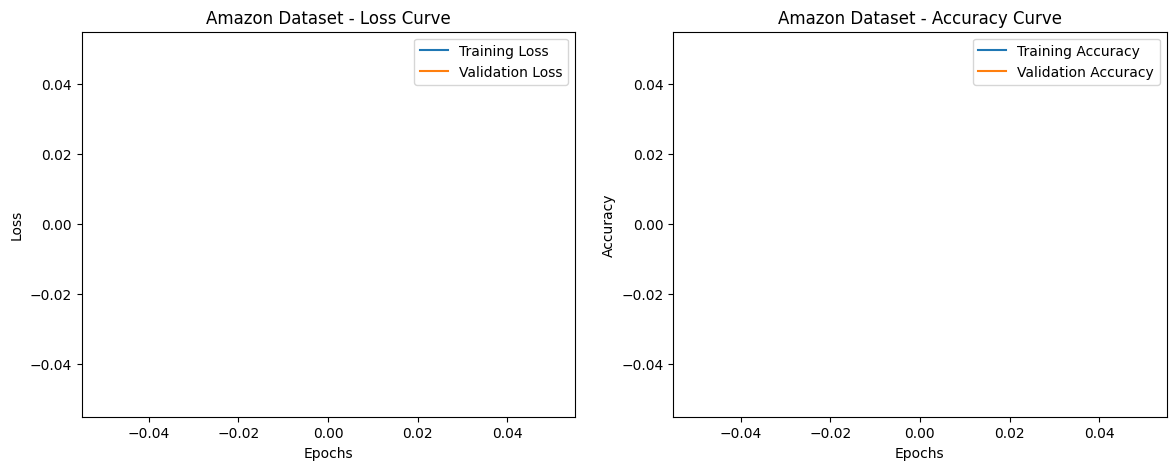

In [ ]:
import matplotlib.pyplot as plt

# --- AMAZON MODEL PLOTS ---

epochs = range(1, len(amazon_train_losses) + 1)

plt.figure(figsize=(14,5))

# LOSS PLOT
plt.subplot(1, 2, 1)
plt.plot(epochs, amazon_train_losses, label='Training Loss')
plt.plot(epochs, amazon_val_losses, label='Validation Loss')
plt.title('Amazon Dataset - Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# ACCURACY PLOT
plt.subplot(1, 2, 2)
plt.plot(epochs, amazon_train_accs, label='Training Accuracy')
plt.plot(epochs, amazon_val_accs, label='Validation Accuracy')
plt.title('Amazon Dataset - Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
#not used


In [ ]:
history = trainer.state.log_history

train_loss = []
eval_loss = []
eval_accuracy = []

for entry in history:
    if "loss" in entry and "epoch" in entry:
        train_loss.append(entry["loss"])
    if "eval_loss" in entry:
        eval_loss.append(entry["eval_loss"])
    if "eval_accuracy" in entry:
        eval_accuracy.append(entry["eval_accuracy"])


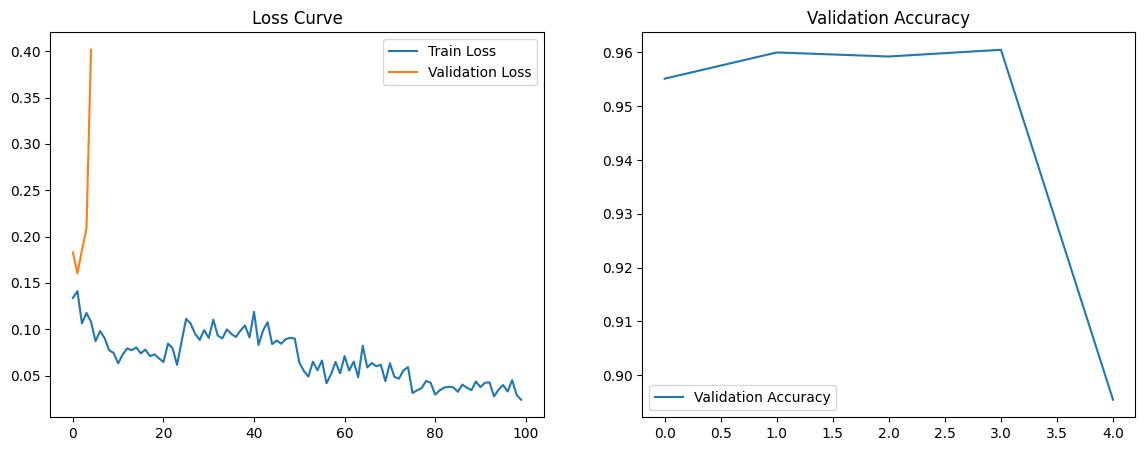

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

# LOSS
plt.subplot(1,2,1)
plt.plot(train_loss, label="Train Loss")
plt.plot(eval_loss, label="Validation Loss")
plt.legend()
plt.title("Loss Curve")

# ACCURACY
plt.subplot(1,2,2)
plt.plot(eval_accuracy, label="Validation Accuracy")
plt.legend()
plt.title("Validation Accuracy")

plt.show()
#idk


In [ ]:
amazon_history = trainer.state.log_history

amazon_train_loss = []
amazon_eval_loss = []
amazon_eval_accuracy = []

for entry in amazon_history:
    if "loss" in entry and "epoch" in entry:
        amazon_train_loss.append(entry["loss"])
    if "eval_loss" in entry:
        amazon_eval_loss.append(entry["eval_loss"])
    if "eval_accuracy" in entry:
        amazon_eval_accuracy.append(entry["eval_accuracy"])
#for amazon roberta model

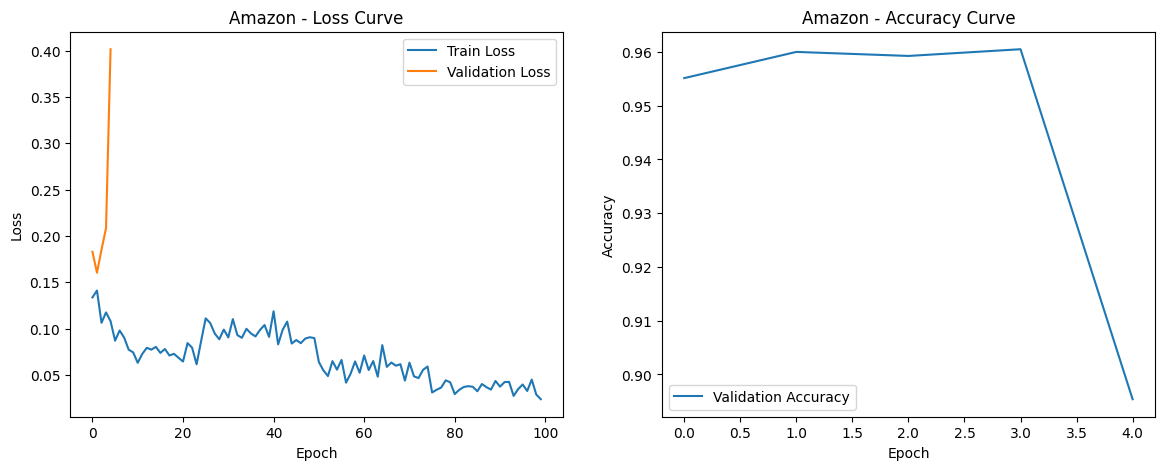

In [ ]:
#plot amazon curves
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

# Loss
plt.subplot(1,2,1)
plt.plot(amazon_train_loss, label='Train Loss')
plt.plot(amazon_eval_loss, label='Validation Loss')
plt.title("Amazon - Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(amazon_eval_accuracy, label='Validation Accuracy')
plt.title("Amazon - Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


In [ ]:
#Extract metrics for IMDB fine-tuning
imdb_history = ft_trainer.state.log_history

imdb_train_loss = []
imdb_eval_loss = []
imdb_eval_accuracy = []

for entry in imdb_history:
    if "loss" in entry and "epoch" in entry:
        imdb_train_loss.append(entry["loss"])
    if "eval_loss" in entry:
        imdb_eval_loss.append(entry["eval_loss"])
    if "eval_accuracy" in entry:
        imdb_eval_accuracy.append(entry["eval_accuracy"])

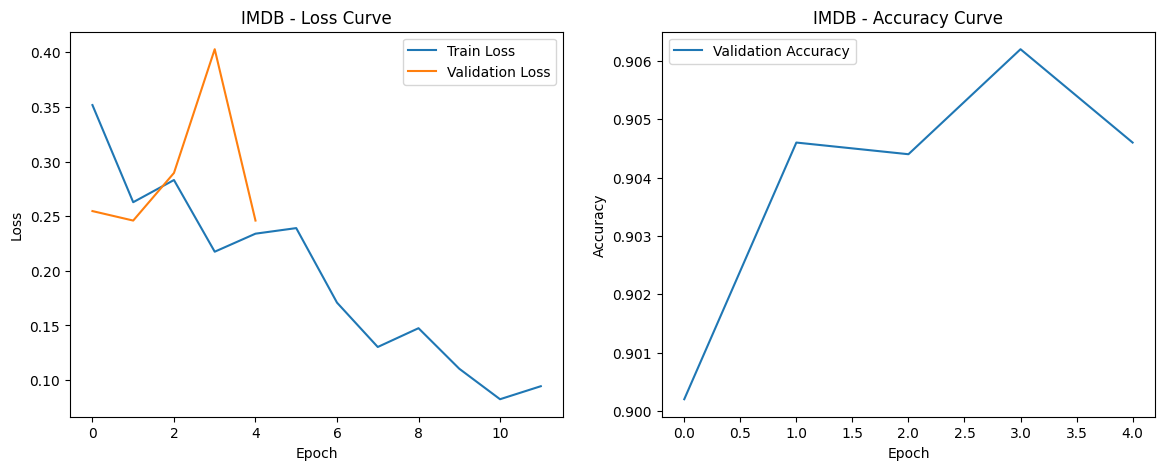

In [ ]:
#Plot IMDB curves
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

# Loss
plt.subplot(1,2,1)
plt.plot(imdb_train_loss, label='Train Loss')
plt.plot(imdb_eval_loss, label='Validation Loss')
plt.title("IMDB - Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(imdb_eval_accuracy, label='Validation Accuracy')
plt.title("IMDB - Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()
